## 1. Prepare data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
from PIL import Image
import numpy as np
from sklearn import model_selection


# Specify image folder
dirs = ['IMAGES_COLOR']

# Initialize a list to store pixel values and labels for images
data = []
label = []

# Read and process image files from each folder one by one and add them to the list
for i, d in enumerate(dirs):
    
    # Create a list of files
    files = os.listdir('./NEU-DET/' + d)
    files_jpg = [file for file in files if file.endswith(".jpg")]
    
    for f in files_jpg:
        # read Image
        img = Image.open('./NEU-DET/' + d + '/' + f, 'r')
    
        # resize
        resize_img = img.resize((200,200)) # has to be 224x224 in VGG16
        
        # divide in RGB and normalize
        r, g, b = resize_img.split()
        r_resize_img = np.asarray(np.float32(r)/255.0)
        g_resize_img = np.asarray(np.float32(g)/255.0)
        b_resize_img = np.asarray(np.float32(b)/255.0)
        rgb_resize_img = np.asarray([r_resize_img, g_resize_img, b_resize_img])
        
        # Adding a processed image to the list
        data.append(rgb_resize_img)
        
        # Labeling
        if 'crazing' in f:
            i=0
        elif 'inclusion' in f:
            i=1
        elif 'patches' in f:
            i=2
        elif 'pitted_surface' in f:
            i=3
        elif 'rolled-in_scale' in f:
            i=4
        elif 'scratches' in f:
            i=5
        
        # Add Image Labels to the List
        label.append(i)
        
# Make numpy array
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

# data partition
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data, label, test_size=0.3)

# Make torch dtype
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

# Merge
train = TensorDataset(train_X, train_Y)
test = TensorDataset(test_X, test_Y)

# minibatch
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True)


## 2. Build NN

In [2]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use GPU if possible

class VGG(nn.Module):

    def __init__(self, features, num_classes=6, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512*6*6, 4096).to(device), # has to be 512*7*7 in VGG16 because of input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096).to(device),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes).to(device),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1).to(device)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model


def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model


def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model


def vgg19_bn(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model

## 3. Model fitting

In [3]:
# instance
model = vgg16()

# Loss func object
criterion = nn.CrossEntropyLoss()

# Optimization object
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)

# fitting
for epoch in range(5): # 1, 10, 100...
    
    total_loss = 0
    
    # data call
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Slope Initialization
        optimizer.zero_grad()
        
        # calc FP
        outputs = model(inputs)
        
        # calc loss
        loss = criterion(outputs, labels)
        
        # calc BP
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # Calc cumulative losses
        total_loss += loss.item()

    # print cum_loss every 50 epochs
    if (epoch+1) % 1 == 0:
        print('Epoch: %d, Total loss: %.6f' % (epoch + 1, total_loss))

print('Finished')

Epoch: 1, Total loss: 71.513450
Epoch: 2, Total loss: 70.803440
Epoch: 3, Total loss: 70.096599
Epoch: 4, Total loss: 67.955374
Epoch: 5, Total loss: 65.411260
Finished


## 4. Test and Eval

GroundTruth:  scratches pitted_surface scratches scratches
Predicted:  pitted_surface pitted_surface inclusion inclusion
Accuracy of the model on test images: 33%


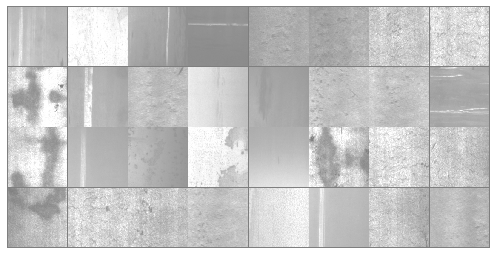

In [4]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu().numpy()    
    image = np.transpose(img, (1, 2, 0))
    
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(image)

#do test
classes = ('crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches')
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images)) #print image

images = images.to(device)
outputs = model(images)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
_, predicted = torch.max(outputs, 1)  # the highest probability
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


#eval accuracy
correct = 0
total = 0

with torch.no_grad():
    
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on test images: %d%%' % (100 * correct / total))

plt.show()